In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
def plcc_metric(y_true, y_pred):  
    mx = K.mean(K.constant(y_true))
    my = K.mean(K.constant(y_pred))
    xm, ym = y_true-mx, y_pred-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    return r_num / r_den

# 정규화 함수 
def MinMaxScaler(data):
    denom = np.max(data,0)-np.min(data,0)            # np.min(data,0) 이었는데 - 값이 있어서 0이 더 작은 값으로 되서 0으로 나누는 경우 에러
    nume = data-np.min(data,0)
    return nume/denom

# 정규화 되돌리기 함수 
def back_MinMax(data,value):
    diff = np.max(data,0)-np.min(data,0)
    back = value * diff + np.min(data,0)
    return back 

df = pd.read_csv("/content/gdrive/MyDrive/tr.csv" , encoding='cp949')
Date = df.iloc[:,0]
df = df.iloc[:, 1:]                   # 맨 앞의 Date는 제외

#df = df.transpose()                  # 행이랑 열 바꿔서 피쳐로 해보자 

from sklearn.preprocessing import MinMaxScaler                    # 얘를 하면 들어온 애의 shape 그대로 다시 back 할 수 있구나
sc = MinMaxScaler()

df = df.interpolate()       # 선형 보간

xy = df.values        

window = 5                          # window size
trainSize = 320                       # 80%만 train
def MinMaxScaler(data):
    denom = np.max(data,0)-np.min(data,0)            # np.min(data,0) 이었는데 - 값이 있어서 0이 더 작은 값으로 되서 0으로 나누는 경우 에러
    nume = data-np.min(data,0)
    return nume/denom

# 정규화 되돌리기 함수 
def back_MinMax(data,value):
    diff = np.max(data,0)-np.min(data,0)
    back = value * diff + np.min(data,0)
    return back 
#trainSet = MinMaxScaler(xy[0:trainSize])
#testSet = MinMaxScaler(xy[trainSize-window:])

trainx = sc.fit_transform((xy[0:trainSize,1:]))
trainy = sc.fit_transform((xy[0:trainSize,[0]]))
testx = sc.fit_transform(xy[trainSize-window:,1:])
testy = sc.fit_transform((xy[trainSize-window:,[0]]))

trainSet = np.concatenate((trainy, trainx), axis=1)
testSet = np.concatenate((testy, testx), axis=1)

predict_day = 4

def buildDataSet(data, window):
    xdata = []
    ydata = []
    for i in range(0, len(data) - window - predict_day):
        xdata.append(data[i:i + window])                         
        ydata.append(data[i + window + predict_day - 1,[0]])                   # 행은 그 다음 행 하나랑, 열은 Number만
    return np.array(xdata), np.array(ydata)
    
trainX, trainY=buildDataSet(trainSet, window)
testX, testY=buildDataSet(testSet, window)

trainX.shape,trainY.shape,testX.shape,testY.shape

((311, 5, 31), (311, 1), (199, 5, 31), (199, 1))

In [ ]:
trainX = trainX.reshape(311,5*31)
testX = testX.reshape(199,5*31)
trainY = trainY.reshape(311,)
testY = testY.reshape(199,)
trainX.shape,trainY.shape,testX.shape,testY.shape

((311, 155), (311,), (199, 155), (199,))

In [ ]:
sum_predict = 0
for i in range(10):
    model = RandomForestRegressor(n_estimators=30) 
    model.fit(trainX,trainY) 
    prediction = model.predict(testX)                         # Random state 없이 랜덤으로 5번 돌려서 평균
    sum_predict += prediction

sum_predict = sum_predict/10

actual = sc.inverse_transform(testY.reshape(-1,1))
predict = sc.inverse_transform(sum_predict.reshape(-1,1))

print("RMSE Evaluate : {}".format(mean_squared_error(actual, predict)**0.5))
print("PCC : {}".format(plcc_metric(actual,predict)))

RMSE Evaluate : 151.31987358389122
PCC : 0.710506796836853


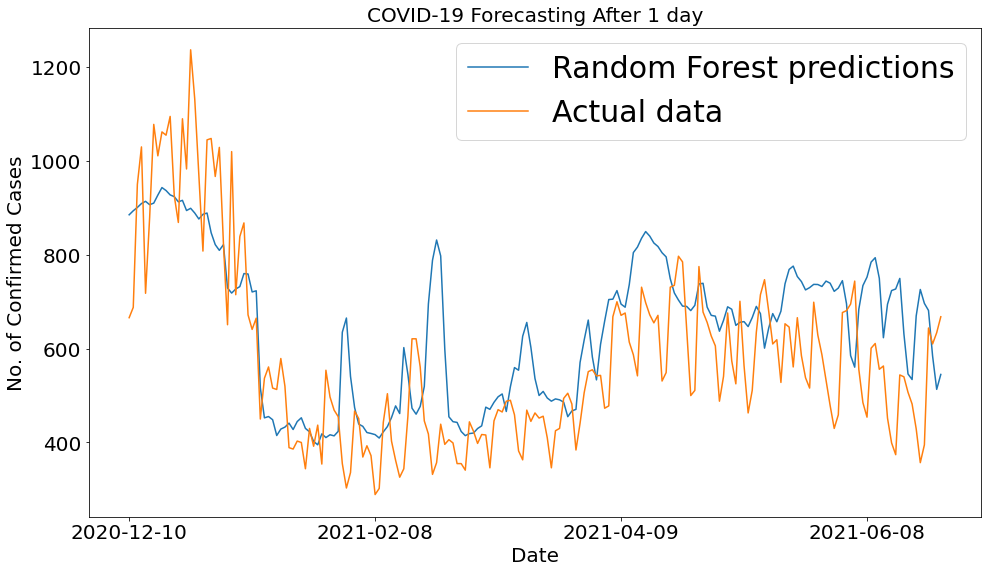

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(Date.iloc[trainSize+predict_day:], predict, label = "Random Forest predictions")
plt.plot(actual,label = "Actual data")
plt.xticks(np.arange(0,240,60), fontsize=20)
plt.yticks(fontsize=20)
plt.title('COVID-19 Forecasting After 1 day',fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('No. of Confirmed Cases' ,fontsize=20)
plt.legend(prop={'size': 30})

In [ ]:
sum_predict = 0
for i in range(10):
    model2 = GradientBoostingRegressor(n_estimators=30)
    model2.fit(trainX,trainY) 
    prediction2 = model2.predict(testX)                         
    sum_predict += prediction2

sum_predict = sum_predict/10

predict2 = sc.inverse_transform(sum_predict.reshape(-1,1))

print("RMSE Evaluate : {}".format(mean_squared_error(actual, predict2)**0.5))
print("PCC : {}".format(plcc_metric(actual,predict2)))

RMSE Evaluate : 168.5737710197492
PCC : 0.6494927406311035


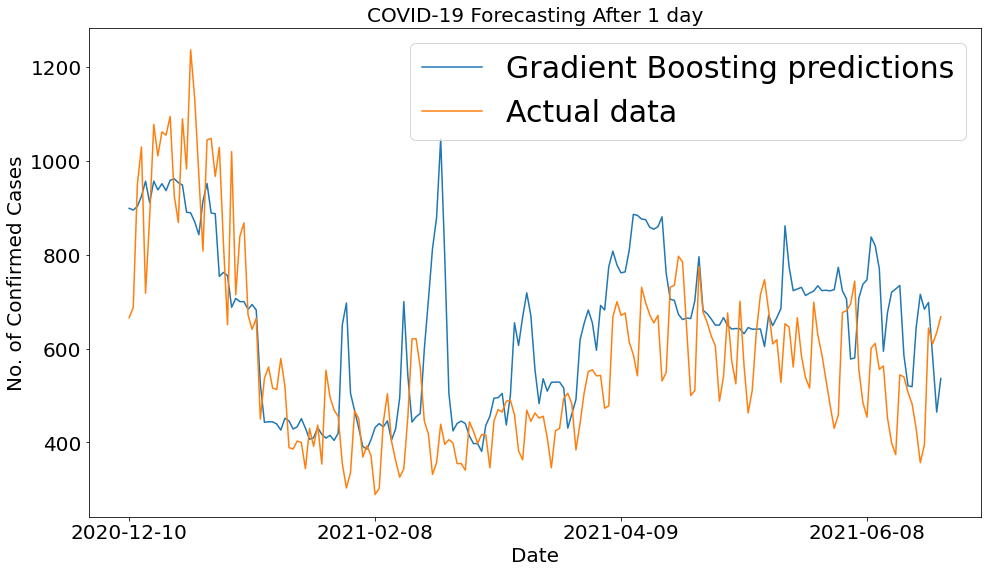

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(Date.iloc[trainSize+predict_day:], predict2, label = "Gradient Boosting predictions")
plt.plot(actual,label = "Actual data")
plt.xticks(np.arange(0,240,60), fontsize=20)
plt.yticks(fontsize=20)
plt.title('COVID-19 Forecasting After 1 day',fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('No. of Confirmed Cases' ,fontsize=20)
plt.legend(prop={'size': 30})

In [ ]:
sum_predict = 0
for i in range(10):
    model3 = AdaBoostRegressor(n_estimators=30)
    model3.fit(trainX,trainY) 
    prediction3 = model3.predict(testX)                         
    sum_predict += prediction3

sum_predict = sum_predict/10

predict3 = sc.inverse_transform(sum_predict.reshape(-1,1))

print("RMSE Evaluate : {}".format(mean_squared_error(actual, predict3)**0.5))
print("PCC : {}".format(plcc_metric(actual,predict3)))

RMSE Evaluate : 153.69910140552344
PCC : 0.6989263296127319


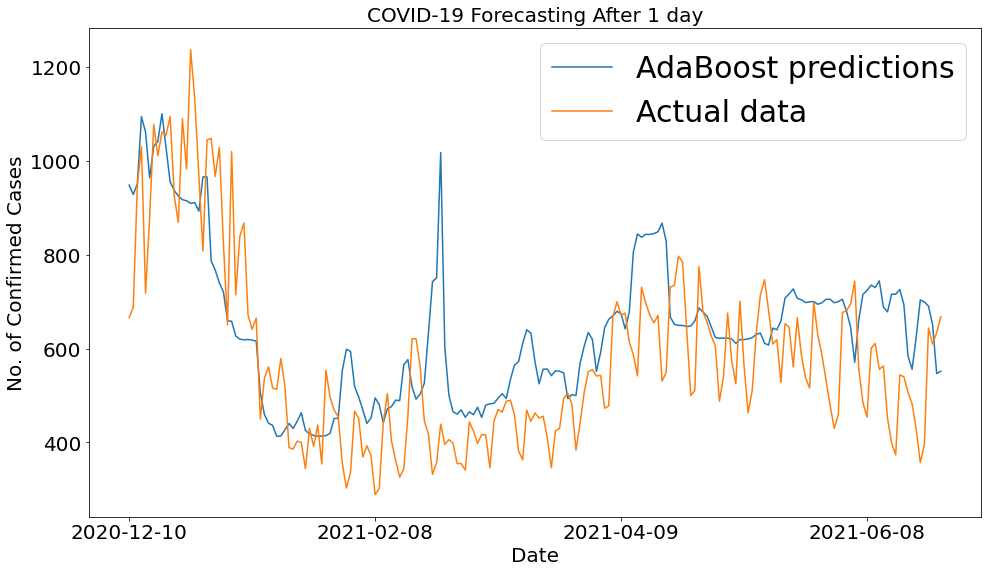

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(Date.iloc[trainSize+predict_day:], predict3, label = "AdaBoost predictions")
plt.plot(actual,label = "Actual data")
plt.xticks(np.arange(0,240,60), fontsize=20)
plt.yticks(fontsize=20)
plt.title('COVID-19 Forecasting After 1 day',fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('No. of Confirmed Cases' ,fontsize=20)
plt.legend(prop={'size': 30})

In [ ]:
from sklearn.linear_model import LinearRegression
sum_predict = 0
for i in range(10):
    model4 = LinearRegression()
    model4.fit(trainX, trainY)
    prediction4 = model4.predict(testX)
    sum_predict += prediction4

sum_predict = sum_predict/10

predict4 = sc.inverse_transform(sum_predict.reshape(-1,1))

print("RMSE Evaluate : {}".format(mean_squared_error(actual, predict4)**0.5))
print("PCC : {}".format(plcc_metric(actual,predict4)))

RMSE Evaluate : 145222.91403484947
PCC : -0.7808673977851868


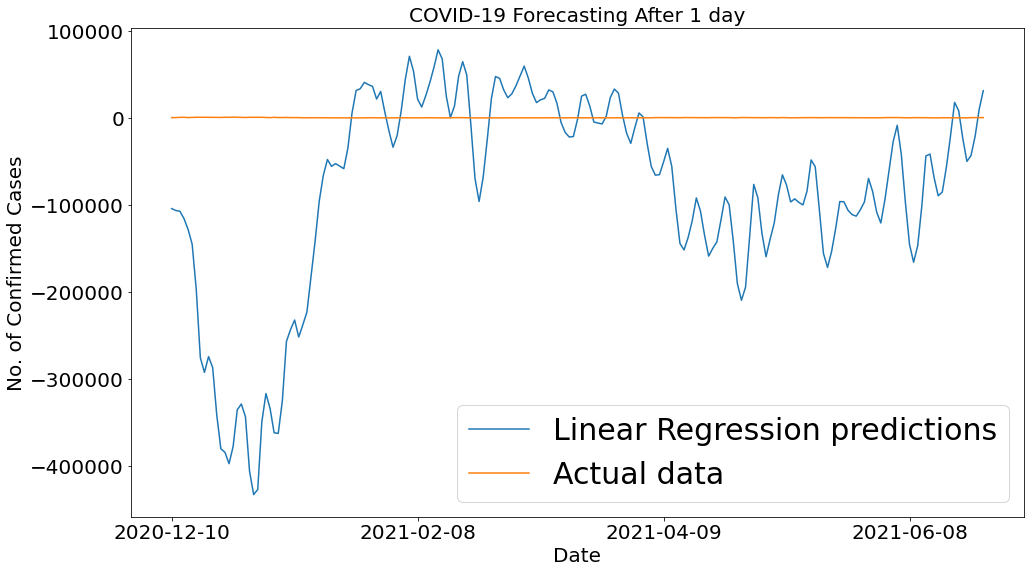

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(Date.iloc[trainSize+predict_day:], predict4, label = "Linear Regression predictions")
plt.plot(actual,label = "Actual data")
plt.xticks(np.arange(0,240,60), fontsize=20)
plt.yticks(fontsize=20)
plt.title('COVID-19 Forecasting After 1 day',fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('No. of Confirmed Cases' ,fontsize=20)
plt.legend(prop={'size': 30})

In [ ]:
from sklearn.neural_network import MLPRegressor
sum_predict = 0
for i in range(10):
    model5 = MLPRegressor(max_iter=30)
    model5.fit(trainX, trainY)
    prediction5 = model5.predict(testX)
    sum_predict += prediction5

sum_predict = sum_predict/10

predict5 = sc.inverse_transform(sum_predict.reshape(-1,1))

print("RMSE Evaluate : {}".format(mean_squared_error(actual, predict5)**0.5))
print("PCC : {}".format(plcc_metric(actual,predict5)))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

RMSE Evaluate : 164.23514023313686
PCC : 0.693108856678009


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


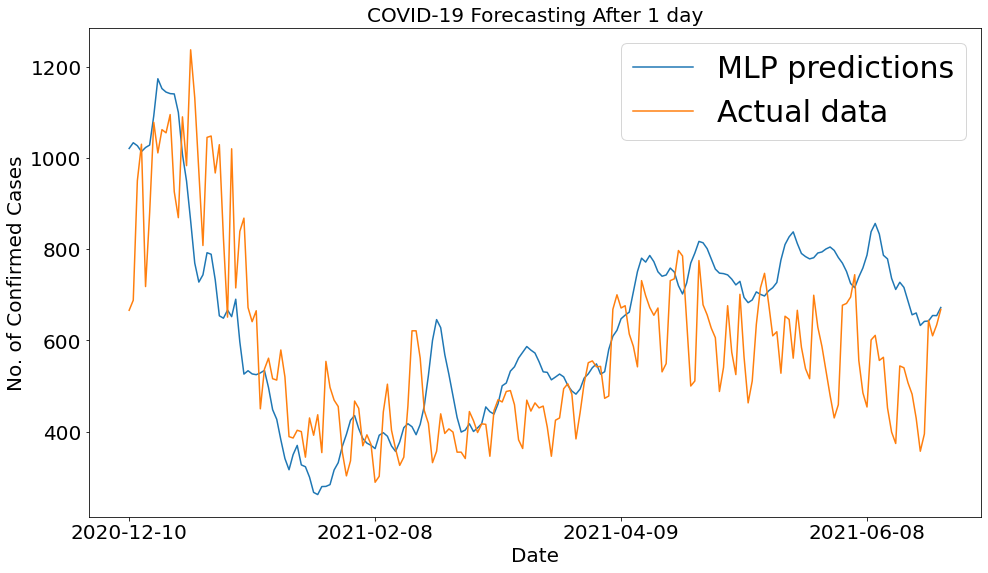

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(Date.iloc[trainSize+predict_day:], predict5, label = "MLP predictions")
plt.plot(actual,label = "Actual data")
plt.xticks(np.arange(0,240,60), fontsize=20)
plt.yticks(fontsize=20)
plt.title('COVID-19 Forecasting After 1 day',fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('No. of Confirmed Cases' ,fontsize=20)
plt.legend(prop={'size': 30})